<a href="https://colab.research.google.com/github/Dakbuu/dak/blob/main/VAE%20%EC%99%84%EC%84%B1%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist

(x_train, t_train), (x_test, t_test) = mnist.load_data() #MNIST 읽어 들이기 
print(x_train.shape, x_test.shape) #28x28의 손으로 쓴문자 이미지가 6만장

(60000, 28, 28) (10000, 28, 28)


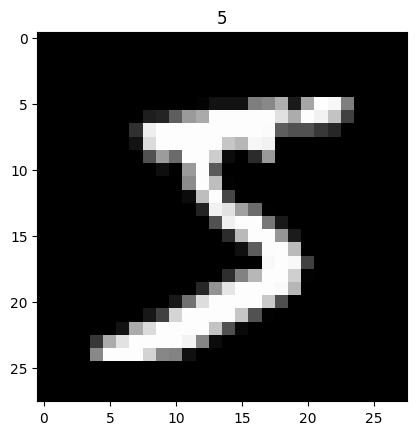

훈련용 데이터의 형태:  (60000, 784) 테스트용 데이터의 형태:  (10000, 784)


In [41]:
#각 픽셀의 값을 0-1의 범위에 넣는다 
x_train = x_train / 255
x_test = x_test / 255

#손으로 쓴 문자 이미지를 1개 표시
plt.imshow(x_train[0].reshape(28, 28), cmap="gray")
plt.title(t_train[0])
plt.show()

#1차원으로 변환한다 
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
print("훈련용 데이터의 형태: ", x_train.shape, "테스트용 데이터의 형태: ", x_test.shape)

In [42]:
from IPython.utils.text import num_ini_spaces
epochs = 10
batch_size = 128
n_in_out = 784 #입출력층의 뉴런 수 
n_z = 2 #잠재 변수의 수(차원 수)
n_mid = 256 #중간층의 뉴런 수 

In [43]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import metrics #평가 함수

In [44]:
from tensorflow.python.keras.layers import Input, Dense, Lambda
from tensorflow.python.keras import backend as K #난수의 발생에 사용

In [45]:
#잠재 변수를 샘플링하기 위한 함수
def z_sample(args):
  mu, log_var = args #잠재 변수의 평균값과 분산의 대수 
  epsilon = K.random_normal(shape=K.shape(log_var), mean=0,stddev=1)
  return mu + epsilon * K.exp(log_var / 2) #Reparametrization Trick에 의해 잠재 변수를 구한다. 

In [46]:
#Encoder
x = Input(shape=(n_in_out,))
h_encoder = Dense(n_mid, activation="relu")(x)
mu = Dense(n_z)(h_encoder)
log_var = Dense(n_z)(h_encoder)
z = Lambda(z_sample, output_shape=(n_z,))([mu, log_var])

In [47]:
#Decoder
mid_decoder = Dense(n_mid, activation="relu") #뒤에서 사용 
h_decoder = mid_decoder(z)
out_decoder = Dense(n_in_out, activation="sigmoid") #뒤에서 사용
y = out_decoder(h_decoder)

In [48]:
# VAE 모델을 생성
model_vae = Model(x, y)

#손실 함수
eps = 1e-7 #log 안이 0이 되는 것을 막는다
rec_loss = K.sum(-x*K.log(y + eps) - (1 - x )*K.log(1 - y + eps)) / batch_size #재구성 오차

In [49]:
reg_loss = - 0.9 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var)) / batch_size #정칙화 항
vae_loss = rec_loss + reg_loss

model_vae.add_loss(vae_loss)
model_vae.compile(optimizer="adam")
model_vae.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 256)          200960      input_7[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 2)            514         dense_9[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 2)            514         dense_9[0][0]                    
____________________________________________________________________________________________

In [50]:
model_vae.fit(x_train, x_train, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(x_test,None))

Epoch 1/10
469/469 [==============================] - 2s 3ms/step - loss: 210.2634 - val_loss: 181.2538
Epoch 2/10
469/469 [==============================] - 1s 3ms/step - loss: 178.2741 - val_loss: 172.1707
Epoch 3/10
469/469 [==============================] - 1s 3ms/step - loss: 173.3187 - val_loss: 169.7058
Epoch 4/10
469/469 [==============================] - 1s 3ms/step - loss: 170.7370 - val_loss: 167.5047
Epoch 5/10
469/469 [==============================] - 1s 3ms/step - loss: 168.7102 - val_loss: 165.9390
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 167.2216 - val_loss: 164.7982
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 166.1248 - val_loss: 163.8121
Epoch 8/10
469/469 [==============================] - 1s 3ms/step - loss: 165.2076 - val_loss: 163.0757
Epoch 9/10
469/469 [==============================] - 1s 3ms/step - loss: 164.4073 - val_loss: 162.5046
Epoch 10/10
469/469 [==============================] - 1s 3ms/st

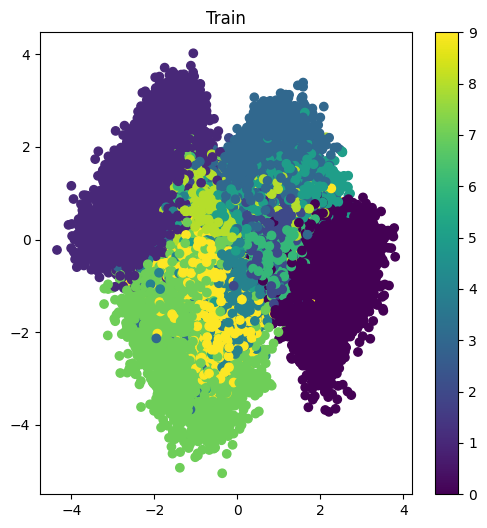

In [51]:
#잠재 변수를 얻기 위한 모델
encoder = Model(x, z)

#훈련 데이터로부터 만든 잠재 변수를 2차원 플롯
z_train = encoder.predict(x_train, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_train[:, 0], z_train[:, 1], c=t_train) #라벨을 색으로 나타낸다
plt.title("Train")
plt.colorbar()
plt.show()

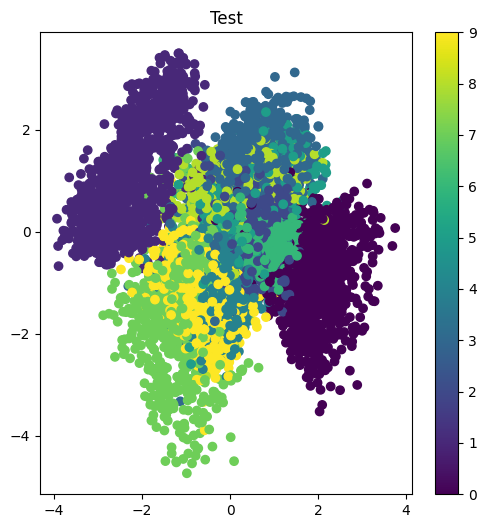

In [52]:
#테스트 데이터를 입력해서 잠재 공간에 2차원 플롯한다 정답 라벨을 색으로 표시
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=t_test)
plt.title("Test")
plt.colorbar()
plt.show()

In [53]:
#이미지 생성기
input_decoder = Input(shape=(n_z,))
h_decoder = mid_decoder(input_decoder)
y = out_decoder(h_decoder)
generator = Model(input_decoder, y)

In [54]:
#이미지를 나열하는 설정
n = 16 #손으로 쓴 문자 이미지는 16 x 16 나열한다
image_size = 28
matrix_image = np.zeros((image_size*n, image_size*n)) #전체 이미지

#잠재 변수 
z_1 = np.linspace (2, -2, n) #각 행
z_2 = np.linspace (-2, 2, n) #각 열 

In [38]:
#잠재 변수를 변화시켜서 이미지를 생성
for i, z1 in enumerate(z_1):
  for j, z2 in enumerate(z_2):
    decoded = generator.predict(np.array([[z2, z1]])) # x축, y축 순서로 넣는다.
    image = decoded[0].reshape(image_size, image_size)
    matrix_image[i*image_size : (i+1)*image_size, j*image_size: (j+1)*image_size] = image

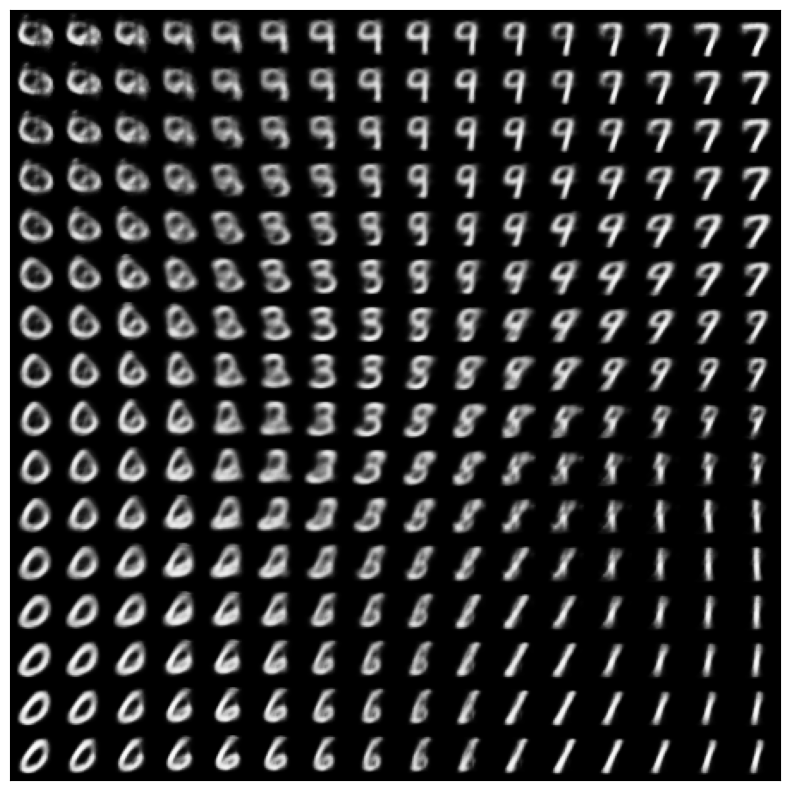

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(matrix_image, cmap="Greys_r")
plt.tick_params(labelbottom=False, labelleft=False, bottom=False,left=False) #축 눈금의 라벨과 선을 지운다
plt.show()